# Modelos usando el algoritmo de redes neuronales

# Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import preprocessing
import informe
import sklearn
from sklearn.model_selection import train_test_split
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Modelo 1: red simple

## Llamado a funciones de preprocesamiento

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encoding(X)

y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Red neuronal

In [4]:
mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model1 = Sequential()
model1.add(Dense(8, input_shape=(40,), activation='tanh'))
model1.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model1.summary()
history = model1.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

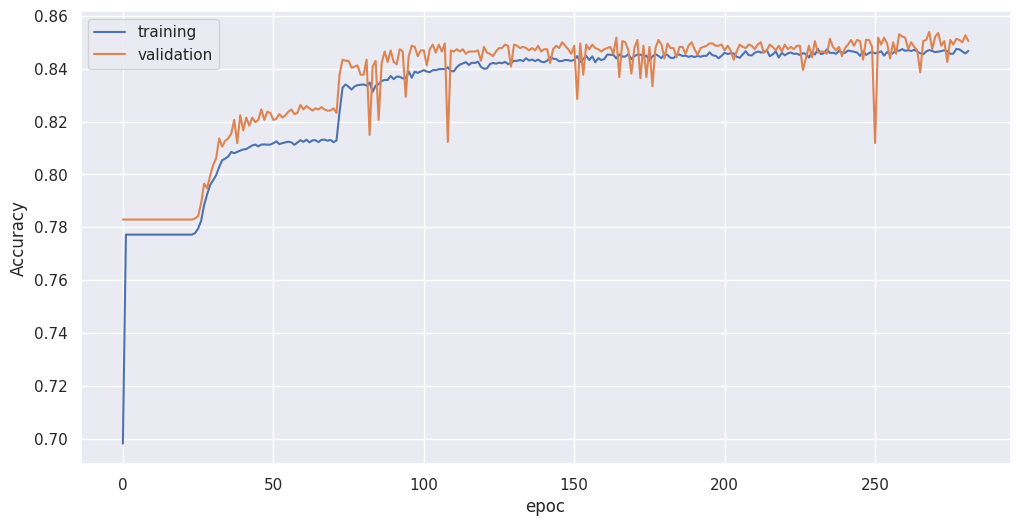

In [5]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Al ser una red simple, con relativamente pocos hiperparámetros, no hizo falta usar regularización. Se ve que no hay overfitting. Se probó con valores mayores de learning rate pero erl entrenamiento era demasiado errático.

## Métricas


AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8411301054355614 
Precision: 0.7029058116232465 
Recall: 0.9199405967328204 
F1-score: 0.6438733363928407 

Curva ROC:


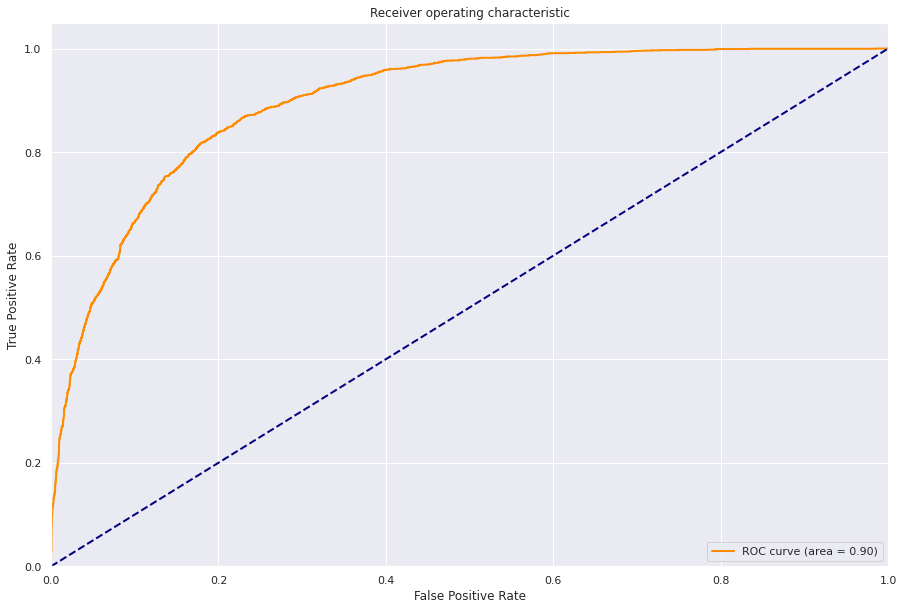

In [6]:
from sklearn.metrics import plot_roc_curve

y_proba = model1.predict(X_test)
y_pred = model1.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC:")
informe.plot_roc(model1, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 2: red simple con datos numéricos escalados

## Llamado a funciones de preprocesamiento

In [7]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encoding(X)

y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

In [8]:
from keras.regularizers import l2

mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model2 = Sequential()
model2.add(Dense(8, input_shape=(40,), activation='tanh', kernel_regularizer=l2(0.0005)))
model2.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()
history = model2.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

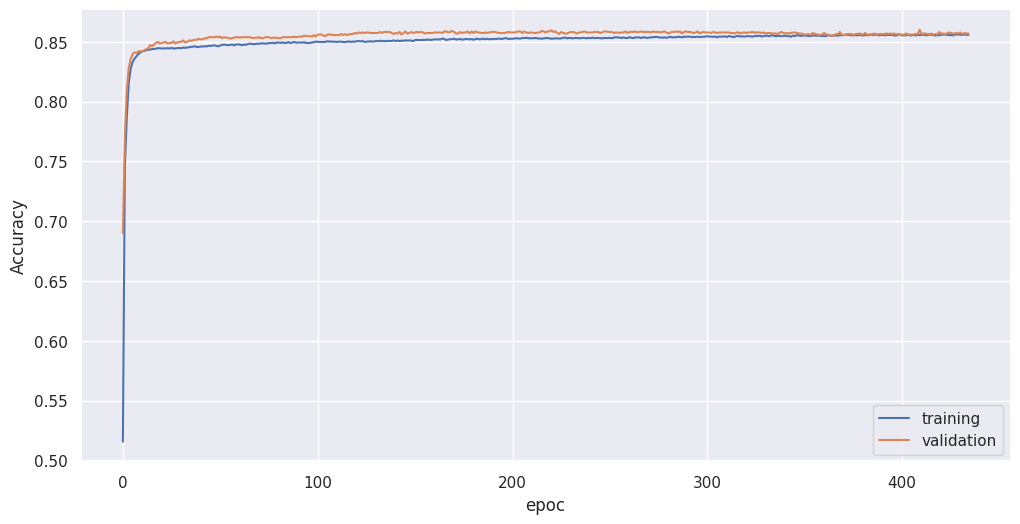

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Se ve que al usar los datos escalados el aprendizaje es menos errático, con menos saltos en el gráfico. Fue necesario usar regularización para evitar overfitting.

## Métricas


AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8511618384686253 
Precision: 0.7276830491474423 
Recall: 0.9266909680032401 
F1-score: 0.6662075298438934 

Curva ROC:


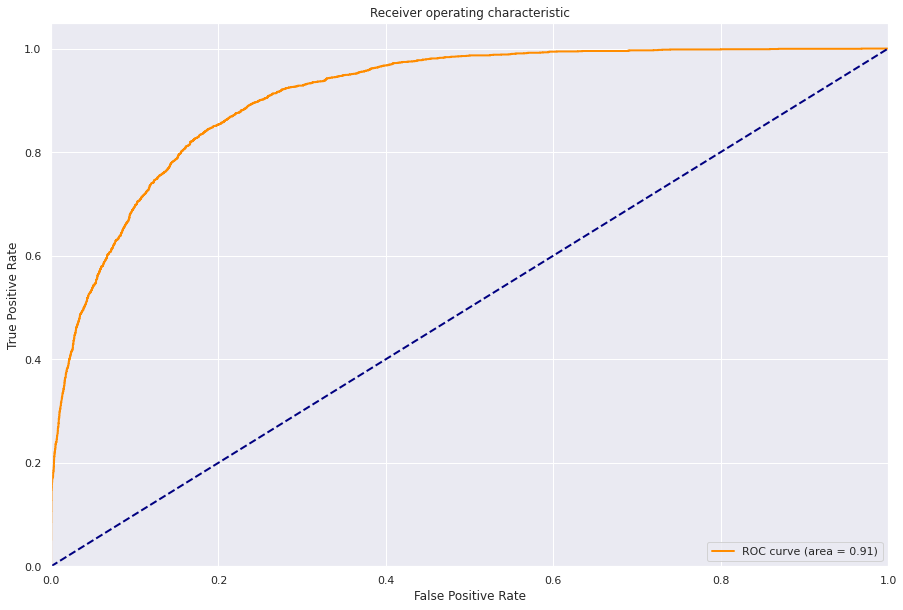

In [10]:
from sklearn.metrics import plot_roc_curve

y_proba = model2.predict(X_test)
y_pred = model2.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC:")
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 3: red con dos capas y activación relu

## Llamado a funciones de preprocesamiento

In [11]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encoding(X)

y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

In [12]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model3 = Sequential()
model3.add(Dense(8, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.0005)))
model3.add(Dense(10, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.0005)))
model3.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model3.summary()
history = model3.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


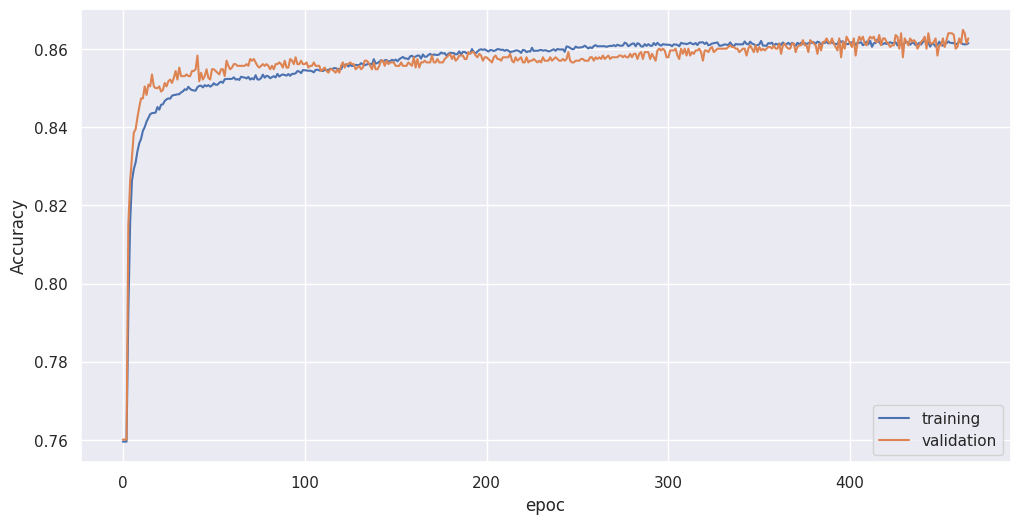

In [13]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Al agregar una capa a la red se ve que hay una mayor tendencia a overfittear. Se ve que el score del training aumenta, mientras que disminuye para validation. Hay que aumentar la regularización para evitarlo.

## Aumentando el learning rate y la regularización

In [14]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=30, mode='max')

model3 = Sequential()
model3.add(Dense(8, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.001)))
model3.add(Dense(10, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.001)))
model3.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0005)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model3.summary()
history = model3.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


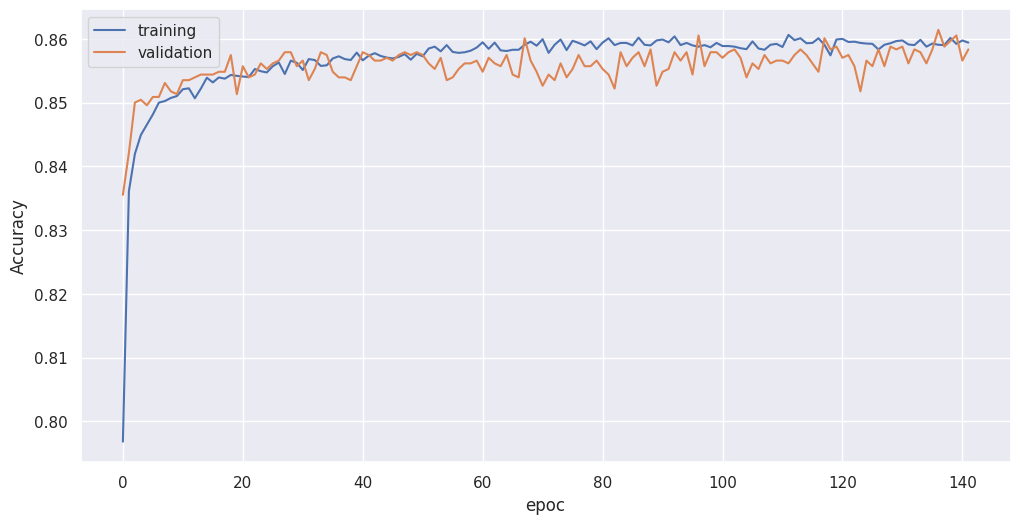

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

Se ve que, al aumentar el learning rate, rápidamente el modelo tiene una buena performance. Se disminuyó el parámetro de patience de early stopping, así como la regularización, para evitar overfitting.

## Métricas


AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8564847988535162 
Precision: 0.7298850574712644 
Recall: 0.9238558120696638 
F1-score: 0.6849438202247191 

Curva ROC:


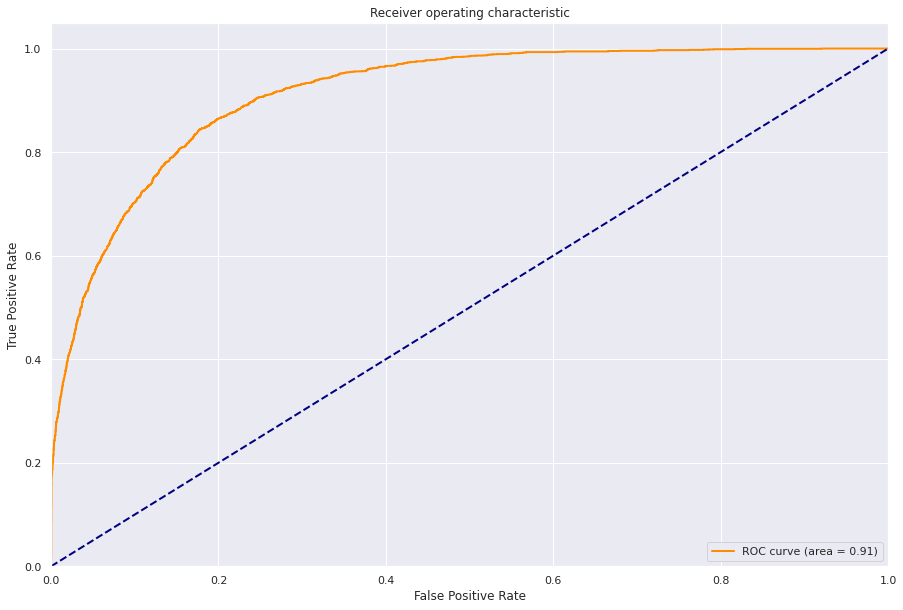

In [16]:
from sklearn.metrics import plot_roc_curve

y_proba = model3.predict(X_test)
y_pred = model3.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC:")
informe.plot_roc(model3, X_test, y_test, classifier=False, y_proba=y_proba)

# Modelo 4: red compleja

## Llamado a funciones de preprocesamiento

In [17]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encoding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, scalar = preprocessing.escalar(X_train)
X_test, scalar = preprocessing.escalar(X_test, scalar)

## Red neuronal

Se entrena una red con más neuronas, usando regularización para evitar el overfitting.

In [18]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model4 = Sequential()
model4.add(Dense(50, input_shape=(40,), activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model4.summary()
history = model4.fit(
    X_train,
    y_train,
    epochs=500,
    validation_split=0.1,
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                2050      
_________________________________________________________________
dense_11 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 7,251
Trainable params: 7,251
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

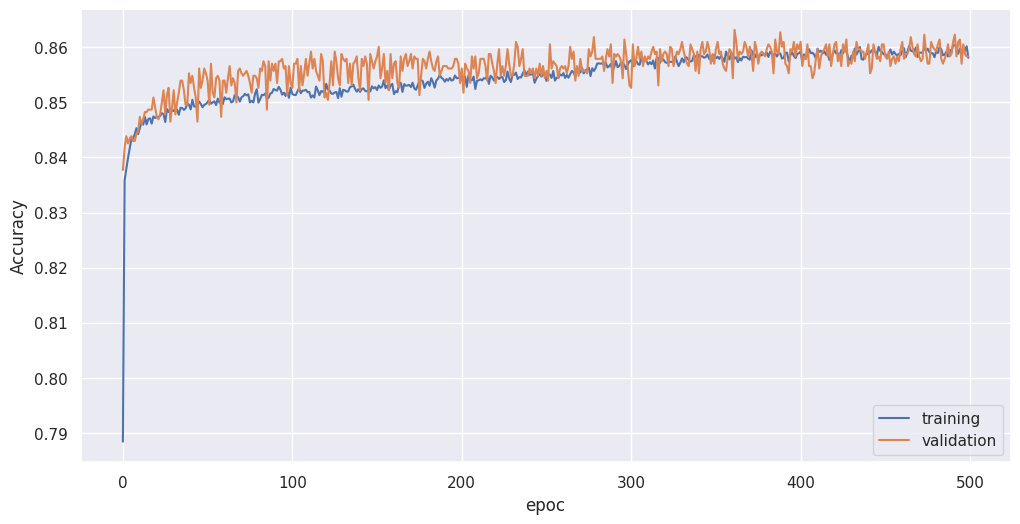

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

 Debido a la cantidad de hiperparámetros de la red, la tendencia a overfittear fue mayor y hubo que reforzar la regularización. Se ve una oscilación del accuracy de los datos de validación.


## Métricas


Se calcularon las métricas para la red 

AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8544375063977889 
Precision: 0.7257444764649376 
Recall: 0.9229107600918051 
F1-score: 0.68001800180018 

Curva ROC:


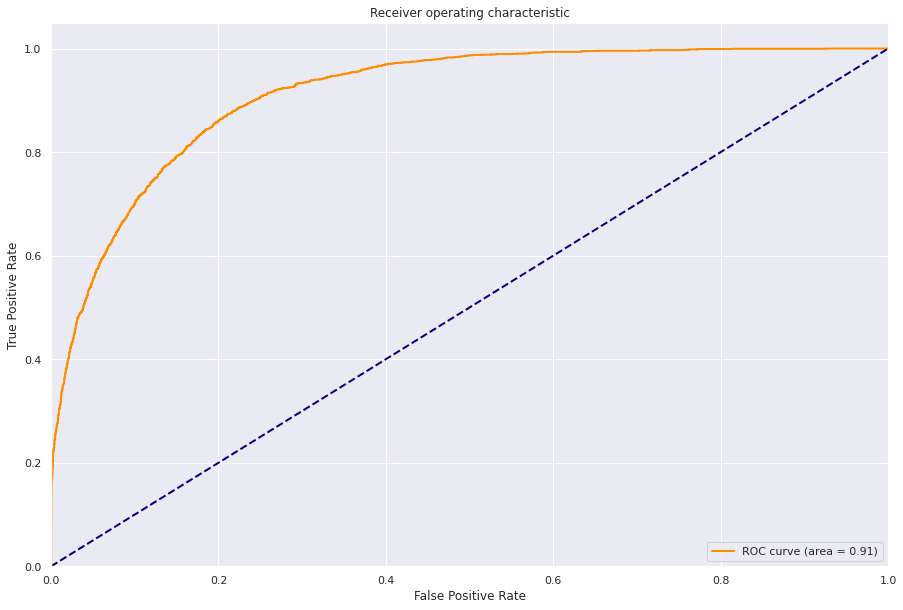

In [20]:
from sklearn.metrics import plot_roc_curve

y_proba = model4.predict(X_test)
y_pred = model4.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC:")
informe.plot_roc(model4, X_test, y_test, classifier=False, y_proba=y_proba)

# Conclusión
      
### Informe del modelo 2 usando los datos del test_holdout

Se pudo ver que al aumentar la complejidad de las redes, no hubo un aumento significativo en la performance. Por eso se eligió al modelo más simple. Además, se vio una ventaja al usar el escalado de los datos, por lo que el modelo seleccionado fue el Modelo 2.

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


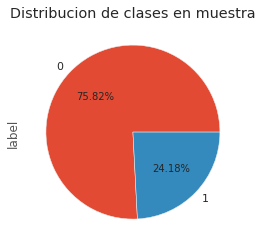

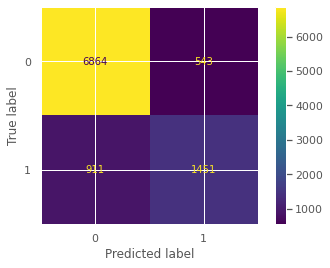

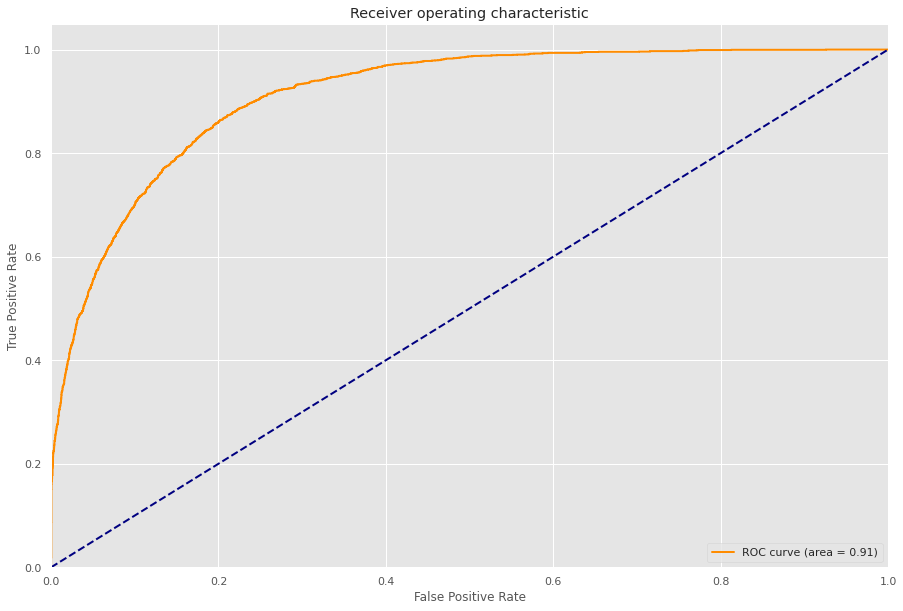

Métricas:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7407
           1       0.73      0.61      0.67      2362

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769



In [21]:
y_pred = model2.predict_classes(X_test)

informe.plt_distribucion_de_clases(y_test)
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred)).plot()
informe.plot_roc(model2, X_test, y_test, classifier=False, y_proba=y_proba)
print('Métricas:')
print(sklearn.metrics.classification_report(y_test, y_pred))

## Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 85%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        El porcentaje de predicciones de bajos ingresos que realmente lo eran fue de 89% y el de predicciones de altos ingresos que realmente lo eran fue del 74% 


- recall:

        Los bajos ingresos reales detectados fueron aproximadamente del 93%, y los altos ingresos reales detectados fueron del 62%. Viendo este resultado, se entiende que el modelo es bueno detectando a los encuestados de bajos ingresos pero confunde al 37% de los altos ingresos como de bajos ingresos.


- matriz de confusion:

        Aquí tambien se puede ver que la mayoria de predicciones de bajos ingresos son correctas, pero parte de los altos ingresos reales no fueron bien predichos.
        También que aproximadamente el 85% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos ya que el accuracy era del 85%).
        
        
- AUC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases con un score de 0.91. Este valor será utilizado para decidir sobre la elección de este modelo.

# Final test

In [22]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.one_hot_encoding(df_test)
df_test, _ = preprocessing.escalar(df_test, scalar)

y_pred = model2.predict_classes(df_test)
informe.save_pred(y_pred, 'red_neuronal')

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
